In [470]:
import numpy as np
edges = np.loadtxt('Gowalla_edges.txt',dtype=int)
print(edges.shape) #1900654 amount of pair examples


(1900654, 2)


In [471]:
#Just for comparison
#Unique users amount
nodes_dat=196591 
#Connections between users
edges_dat=950327
#Total num of check ins
checkins_dat=6442890


In [472]:
#Data preprocessing building message graph==similarity
#Unique users array
users=np.unique(edges)
print(users)
#Unique users amount
n=len(users)
print(n)

# S, A, R matrices (n,n) but dimension is too large even for sparse matrix, thats why need to concatenate parts 
#or use np.array
connections=[]
similarity_list=[]

for i in range (0,len(edges)):
    #users connection from ->to
    #pair=(edges[i][0],edges[i][1])
    connections.append((edges[i][0],edges[i][1]))
    #each connection markes as 1 in simularity array 
    similarity_list.append(1)
    
for user in range(0,n):
    connections.append((user,user))# self-connection add as pair
#transform to numpy array for memory
similarity_array = np.array(similarity_list) #this is without self-simularity
print(np.shape(similarity_array)) #1900654 all pairs were added 
print(np.shape(connections))#(2097245, 2) =1900654(pairs)+196591(self)

[     0      1      2 ... 196588 196589 196590]
196591
(1900654,)
(2097245, 2)


In [473]:
def update_responsibility(S,A,R_old,connections):
    #sum in formula
    V = S + A#(2097245
    #need to store 2 max sum arrays because we need to avoid self value being max value
    #initialize as -inf
    first_max=np.repeat(-np.inf, n)#np.full(-np.inf,n)#196591 as rows
    second_max=np.repeat(-np.inf, n)
    pair_max=np.repeat(np.inf, n)

    for idx,pair in enumerate(connections):
        #print(pair)
        #connection and V have same dimension and idxes order
        #for pair[0] first user update max and remember 
        if first_max[pair[0]]<V[idx]:
            second_max[pair[0]]=first_max[pair[0]]
            first_max[pair[0]]=V[idx]
            #store number of second user with which first one has max V
            pair_max[pair[0]]=pair[1]
        elif second_max[pair[0]]<V[idx]:
            second_max[pair[0]]=V[idx]
    #because we need to substract max from it        
    R=S.copy()   
    for idx,pair in enumerate(connections):
        #if it is self responsibility value then take second_max 
        if pair_max[pair[0]] == pair[1]:
            R[idx]-=second_max[pair[0]]
        else:
            R[idx]-=first_max[pair[0]]
        
    #return R_old*damping+(1-damping)*R
    return R

In [474]:
def update_availability(A,R,connections):
    A_old=A.copy()
    #drop self-resp values
    R_copy = R.copy()
    #max between 0 and responsibility value (if negative make it zero), a(k,k) counted here
    #len(edges) meaning we dont consider self-r values
    for i in range(0,len(edges)):
        #r[r < 0] = 0
        if R_copy[i] < 0:
            R_copy[i] = 0
    positive_r = np.repeat(0, n) #np.full(0,n)
    
    for idx, pair in enumerate(connections):
        positive_r[pair[1]] += R_copy[idx]
    
    for idx, pair in enumerate(connections):
        A[idx] = positive_r[pair[1]] - R_copy[idx]
    #count min
    for i in range(0,len(edges)):
        A[i] = np.min([0, A[i]])
    #return A_old*damping+(1-damping)*A
    return A

In [475]:
def get_exemplars(R,A,connections,transitivity_param):
    temp = np.repeat(-np.inf, n)# stores max values for comparison
    exemplars = dict() #store as dictionary with indexes because otherwise indexes is non int values for transitivity
    #sum responsibility and availability 
    value_sum = R+A
    # for each user get exemplar
    for idx, pair in enumerate(connections):
        #find max val
        #if value_sum for this user is bigger than stored max value, then update
        # and add user idx with which this msx value is achieved as exemplar for initial user
        if value_sum[idx] > temp[pair[0]]:
            temp[pair[0]] = value_sum[idx]
            exemplars[pair[0]] = pair[1] #for user_1 store user_2 as exemplar (if value_sum with user_2 is bigger)
    for i in range(transitivity_param):        
        for exempl_a in exemplars.keys(): 
            exempl_b = exemplars[exempl_a] #exemplar b for user a
            if exemplars[exempl_b] != exempl_b: #if b is not exemplar for b (self-exemplar)
                exempl_с = exemplars[exempl_b] #find exemplar for b, it is c
                exemplars[exempl_a] = exempl_с #update main: put exemplar c as exemplae for a  
    return exemplars

In [476]:
def affinity_propagation(similarity_array_input,connections,num_iterations,self_similarity_param):
    #Initialization 
    #similarity: 1=if there is a connection between users, 0=if there is no connection
    #self_similarity_param=if it is self-connection
    similarity_array=np.append(similarity_array_input,np.repeat(self_similarity_param,n))
    #as zero
    responsibility_array=np.repeat(0, similarity_array.shape[0])#np.zeros(len(similarity_array)) #(2097245,)
    availability_array=np.repeat(0, similarity_array.shape[0]) #np.zeros(len(similarity_array)) #(2097245,)
    #print(np.shape(responsibility_array)) 
    for i in range(0,num_iterations):
        #Step 1
        responsibility_array=update_responsibility(similarity_array,availability_array,responsibility_array,connections)
        #Step 2
        availability_array=update_availability(availability_array,responsibility_array,connections)
        #print(i)
    #Based on counted values get examplars as max for each cluster    
    exemplars=get_exemplars(responsibility_array,availability_array,connections,transitivity_param=5)
    
    return exemplars

#affinity_propagation(similarity_array,connections,1,-1.5)


In [477]:
res_exemplars = affinity_propagation(similarity_array,connections,num_iterations=10,self_similarity_param=-1.5)

In [478]:
#Amount of clusters
clusters=sorted(list(set(res_exemplars.values())))#get unique values from dict by set
print("Clusters amount:", len(clusters))

Clusters amount: 17955


In [479]:
clusters_for_df=(list(res_exemplars.values()))
# np.savetxt('clusters.txt', clusters_for_df, delimiter=',')
# print(res_exemplars.values())
# print("here")
# print(clusters_for_df)

In [480]:
#Size of clusters
cluster_size = dict()# dictionary to store cluster with amount of its users
for exemplar in res_exemplars.values():
    if exemplar not in cluster_size:
        cluster_size[exemplar] = 1
    else:
        cluster_size[exemplar] += 1
print("Max cluster size:", max(cluster_size.values()))
print("Min cluster size", min(cluster_size.values()))

Max cluster size: 16100
Min cluster size 1


In [481]:
#print(list(res_exemplars.values()))
#print ("Clusters values:", sorted(list(set(res_exemplars.values()))))
#print ("Clusters values:", clusters)


**Histogram of all clusters**

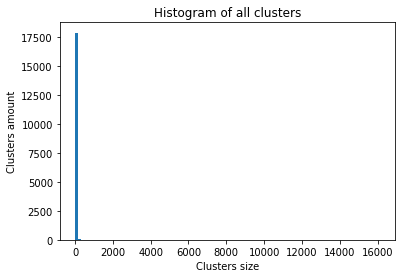

In [482]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(cluster_size.values(), bins=100)
plt.xlabel("Clusters size")
plt.ylabel("Clusters amount")
plt.title("Histogram of all clusters")
plt.show()

**Histogram of most popular sized clusters**

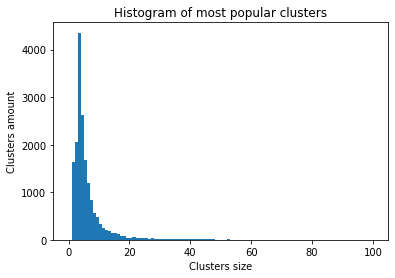

In [483]:
plt.hist(cluster_size.values(), bins=100, range=(0, 100))
plt.xlabel("Clusters size")
plt.ylabel("Clusters amount")
plt.title("Histogram of most popular clusters")
plt.show()

**Histogram of small sized clusters**

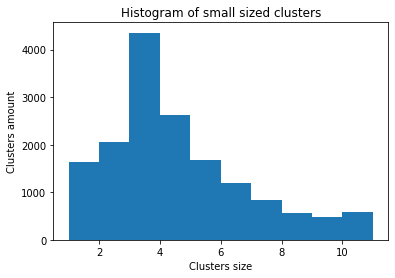

In [484]:
plt.hist(cluster_size.values(),bins= range(1,12), range=(0, 11))
plt.xlabel("Clusters size")
plt.ylabel("Clusters amount")
plt.title("Histogram of small sized clusters")
plt.show()

**Histogram of big sized clusters**

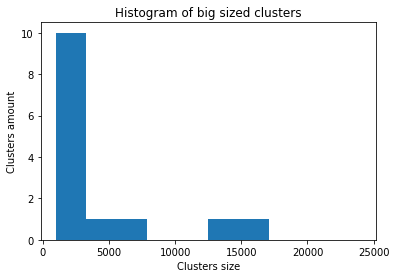

In [485]:
plt.hist(cluster_size.values(), bins=10, range=(1000, 24000))
plt.xlabel("Clusters size")
plt.ylabel("Clusters amount")
plt.title("Histogram of big sized clusters")
plt.show()

In [486]:
import pandas as pd
df_checkins = pd.read_csv("Gowalla_totalCheckins.txt", sep="	", header=None)[[0, 4]]
df_checkins.columns = ["user_id", "location_id"]
print(len(df_checkins)) #size less by 599 because drop duplicates is used
df_checkins.head()
#chekins = np.loadtxt('Gowalla_totalCheckins.txt')
#print(checkins.shape) #1900654 amount of pair examples


6442892


,user_id,location_id
0,0,22847
1,0,420315
2,0,316637
3,0,16516
4,0,5535878


In [487]:
clusters = clusters_for_df
print(len(clusters))
df_clusters = pd.DataFrame(clusters)
df_clusters = df_clusters.reset_index()
df_clusters.columns = ["user_id", "cluster_id"]
print(len(df_clusters))
df_clusters.head()

196591
196591


,user_id,cluster_id
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4


In [488]:
df = pd.merge(df_checkins, df_clusters, on=['user_id'])
print(len(df))
df.head()

6442892


,user_id,location_id,cluster_id
0,0,22847,0
1,0,420315,0
2,0,316637,0
3,0,16516,0
4,0,5535878,0


In [489]:
users_with_location = np.unique(df_checkins.user_id)
print(len(users_with_location)) #107092 =users who left location ,all users =196591 (so, 90000 missing)


107092


In [490]:
#make train test for users
from sklearn.model_selection import train_test_split
train_users, test_users = train_test_split(users_with_location, test_size=0.1, shuffle=True)
print(np.shape(train_users))
print(np.shape(test_users))

(96382,)
(10710,)


In [491]:
#cut this train and test inside df initial with locations
train_checkins = df.loc[df.user_id.isin(train_users)]
test_checkins = df.loc[df.user_id.isin(test_users)]
test_checkins.head()

,user_id,location_id,cluster_id
2712,9,3010334,9
2713,9,39610,9
2714,9,123529,9
2715,9,114086,9
2716,9,347561,9


In [492]:
#get TOP10 locations for train as array
top10_locations = list(train_checkins.groupby(by='location_id')['location_id'].count().sort_values(ascending = False).iloc[:10].index)
print(top10_locations)
#train_loc_ratings = train_checkins.groupby(by = ["cluster_id", "location_id"])["location_id"].count()
#train_loc_ratings = train_loc_ratings.reset_index(name='rating').sort_values(by = ["cluster_id", "rating"], ascending = False)


[55033, 19542, 9410, 10259, 9246, 58725, 10190, 23256, 14470, 9241]


In [493]:
#for tracking top values of cluster location
#so, count rating=amount of times user in this cluster check-ins in this location 
train_loc_ratings = train_checkins.groupby(by = ["cluster_id", "location_id"])["location_id"].count()

train_loc_ratings = train_loc_ratings.reset_index(name='rating').sort_values(by = ["cluster_id", "rating"], ascending = False)
train_loc_ratings.head()

,cluster_id,location_id,rating
3081283,196539,471724,1
3081284,196539,4555073,1
3081267,196531,903295,2
3081276,196531,2403285,2
3081260,196531,211756,1


In [494]:
#unused
# def get_tp(user_locations,top_locations):
#     for location in user_locations:
#         if location in top_locations:
#             tp+=1
#     return tp
#Strange count
# #precision=tp / (tp + fp)=len(test_users)
# tp_base = 0
# tp_cluster = 0
# denom=len(test_users)*10

# for user in test_users:
#     user_locations = test_checkins.loc[test_checkins.user_id == user, "location_id"].values #usually an array
#     cluster = clusters[user]
#     #tp_base+=get_tp(user_locations,top10_locations)
#     for location in user_locations:
#         if location in top10_locations:
#             tp_base+=1
            
#     if (cluster in train_loc_ratings.cluster_id): #if we have info for this cluster      
#         top_cluster = train_loc_ratings.loc[train_loc_ratings.cluster_id == cluster, "location_id"].values
#         #check if there is 10 locations, otherwise dont change
#         try:
#             top10_clusters_loc = set(top_cluster[:10])
#         except:
#             top10_clusters_loc = set(top_cluster)
# #         if cluster==0:    
# #             print(top10_clusters_loc)  
#         #tp_cluster+=get_tp(user_locations,topK_cluster)
#         for location in user_locations:
#             if location in top10_clusters_loc:
#                 tp_cluster+=1
        
# base_precision=tp_base/denom
# cluster_precision=tp_cluster/denom
# print("Base prectidion: ", base_precision)
# print("Cluster prectidion: ", cluster_precision)

# #Same metrics but working much longer due to iterrows() 
# # tp=0
# # for index, row in test_checkins.iterrows():
# #     if row["location_id"] in top10_locations:
# #             tp += 1
# # base_precision=tp/len(test_users)/10
# # print(base_precision)   

In [495]:
def get_tp(top_data, pred_data, k = 10):
    try:
        top_data = set(top_data[:k])
    except:
        top_data = set(top_data)
    pred_data = set(pred_data)
    return len(top_data.intersection(pred_data)) #len of equal values in lists

amount_counter = 10*len(test_users)
tp_base = 0
tp_cluster = 0
denom=len(test_users)*10

for user in test_users:
    cluster = clusters[user]
    user_locations = test_checkins.loc[test_checkins.user_id == user, "location_id"].values
    if (cluster in train_loc_ratings.cluster_id): #if we have info for this cluster      
        top_cluster = train_loc_ratings.loc[train_loc_ratings.cluster_id == cluster, "location_id"].values        
        tp_cluster += get_tp(top_cluster, user_locations)

    tp_base += get_tp(top10_locations, user_locations)

base_precision=tp_base/denom
cluster_precision=tp_cluster/denom
print("Base prectidion: ", base_precision)
print("Cluster prectidion: ", cluster_precision)

Base prectidion:  0.017478991596638654
Cluster prectidion:  0.037572362278244634
